In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_data = pd.read_csv('./applestore.csv', index_col=0)
print(raw_data.shape)
print(list(raw_data.columns))
raw_data.drop(columns=['id', 'currency', 'track_name'], inplace=True)
raw_data.head()

(7197, 16)
['id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
1,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
2,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
3,100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
4,128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
5,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [21]:
df = raw_data.copy()

for col in df.columns:
    print(col, '-', len(df[col].unique()), 'uniq vals')

size_bytes - 7107 uniq vals
price - 36 uniq vals
rating_count_tot - 3185 uniq vals
rating_count_ver - 1138 uniq vals
user_rating - 10 uniq vals
user_rating_ver - 10 uniq vals
ver - 1590 uniq vals
cont_rating - 4 uniq vals
prime_genre - 23 uniq vals
sup_devices.num - 20 uniq vals
ipadSc_urls.num - 6 uniq vals
lang.num - 57 uniq vals
vpp_lic - 2 uniq vals


In [22]:
# look at ver (should there be 4 periods?)

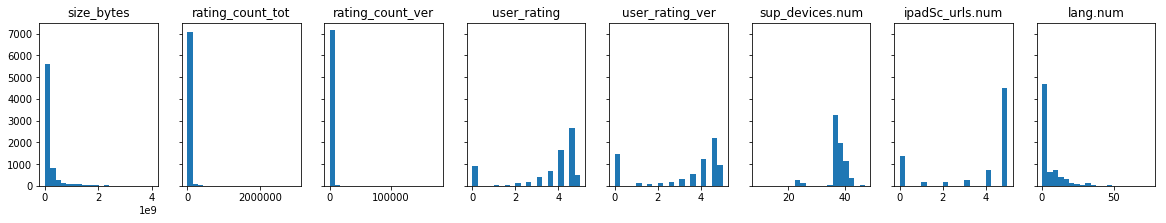

In [23]:
continuous_cols = ['size_bytes', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num']

fig, axes = plt.subplots(1, len(continuous_cols), figsize=(20, 3), sharey=True)

for idx, col in enumerate(continuous_cols):
    axes[idx].hist(df[col], bins=20)
    axes[idx].set_title(col)

plt.show()

df['high_rating'] = df['user_rating'] >= 4.0
df['high_rating_ver'] = df['user_rating_ver'] >= 4.0

In [24]:
categ_cols = ['price', 'ver', 'cont_rating', 'prime_genre', 'vpp_lic']

def get_minor_v(x):
    if len(x) > 1:
        return x[1]
    else:
        return 0

df['major_v'] = df['ver'].str.split('.').apply(lambda x:x[0])
df['major_v'] = pd.to_numeric(df['major_v'], errors='coerce').fillna(0).astype(np.int64)

df['minor_v'] = df['ver'].str.split('.').apply(get_minor_v)
df['minor_v'] = pd.to_numeric(df['minor_v'], errors='coerce').fillna(0).astype(np.int64)

df.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,high_rating,high_rating_ver,major_v,minor_v
1,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,True,True,6,3
2,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,True,False,8,2
3,100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,False,True,5,0
4,128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,True,True,5,10
5,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,True,True,7,5


In [25]:
df['free'] = df['price'].apply(lambda x: 1 if x == 0 else 0)

rating_dummies = pd.get_dummies(df['cont_rating'])
genre_dummies = pd.get_dummies(df['prime_genre'])

for rating in rating_dummies:
    df[rating] = rating_dummies[rating]
    
for genre in genre_dummies:
    df[genre] = genre_dummies[genre]

df.drop(columns=['ver', 'cont_rating', 'prime_genre'], inplace=True)
df.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,...,News,Photo & Video,Productivity,Reference,Shopping,Social Networking,Sports,Travel,Utilities,Weather
1,100788224,3.99,21292,26,4.0,4.5,38,5,10,1,...,0,0,0,0,0,0,0,0,0,0
2,158578688,0.00,161065,26,4.0,3.5,37,5,23,1,...,0,0,1,0,0,0,0,0,0,0
3,100524032,0.00,188583,2822,3.5,4.5,37,5,3,1,...,0,0,0,0,0,0,0,0,0,1
4,128512000,0.00,262241,649,4.0,4.5,37,5,9,1,...,0,0,0,0,1,0,0,0,0,0
5,92774400,0.00,985920,5320,4.5,5.0,37,5,45,1,...,0,0,0,1,0,0,0,0,0,0


In [26]:
from sklearn.preprocessing import normalize

cols_to_norm = continuous_cols
# REMEMBER PRICE IS CONTINUOUS

# Normalize data before clustering
df = df.dropna(subset=cols_to_norm)

cluster_df = df.copy()
cluster_df[cols_to_norm] = normalize(cluster_df[cols_to_norm])
    
cluster_df = pd.concat([cluster_df[cols_to_norm], cluster_df[cluster_df.columns.difference(cols_to_norm)]], axis=1)
print(cluster_df.shape[0], 'rows;', cluster_df.shape[1], 'columns')

cluster_df.head()

7197 rows; 42 columns


,size_bytes,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num,12+,17+,...,Travel,Utilities,Weather,free,high_rating,high_rating_ver,major_v,minor_v,price,vpp_lic
1,1.000000,0.000211,2.579666e-07,3.968718e-08,4.464807e-08,3.770282e-07,4.960897e-08,9.921794e-08,0,0,...,0,0,0,0,True,True,6,3,3.99,1
2,0.999999,0.001016,1.639564e-07,2.522406e-08,2.207105e-08,2.333225e-07,3.153007e-08,1.450383e-07,0,0,...,0,0,0,1,True,False,8,2,0.00,1
3,0.999998,0.001876,2.807284e-05,3.481748e-08,4.476534e-08,3.680705e-07,4.973926e-08,2.984356e-08,0,0,...,0,0,1,1,False,True,5,0,0.00,1
4,0.999998,0.002041,5.050102e-06,3.112543e-08,3.501611e-08,2.879103e-07,3.890679e-08,7.003222e-08,1,0,...,0,0,0,1,True,True,5,10,0.00,1
5,0.999944,0.010626,5.734017e-05,4.850202e-08,5.389113e-08,3.987944e-07,5.389113e-08,4.850202e-07,0,0,...,0,0,0,1,True,True,7,5,0.00,1


In [27]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA

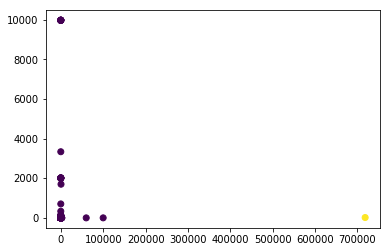

In [28]:
pca_2 = PCA(2).fit_transform(cluster_df)
kmeans_2_pred = KMeans(n_clusters=2, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_2_pred)
plt.show()

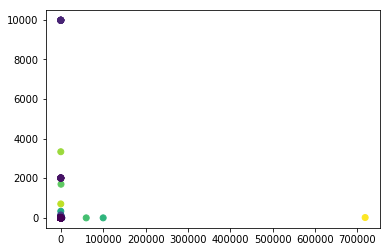

In [29]:
bandwidth = estimate_bandwidth(pca_2, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_pred = ms.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=ms_pred)
plt.show()